## Fixing the random seed

In [1]:
import numpy as np
import random
np.random.seed(43)
random.seed(43)

## Utility functions
Define two utility functions, needed for image loading and visualization

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def display_images(image_batch, cols=8, rows=4):
    plt.figure(figsize=(20, 16))
    height, width = image_batch.shape[1:3]
    reshaped = np.reshape(image_batch, (rows, cols, height, width, 3)) \
            .transpose(0, 2, 1, 3, 4) \
            .reshape(rows*height, cols * width, 3)
    plt.imshow(reshaped)
    plt.axis('off')
    plt.show()


## Preview data
The previous two functions allow us to visualize the images present in ./images directory that we’ll be working with

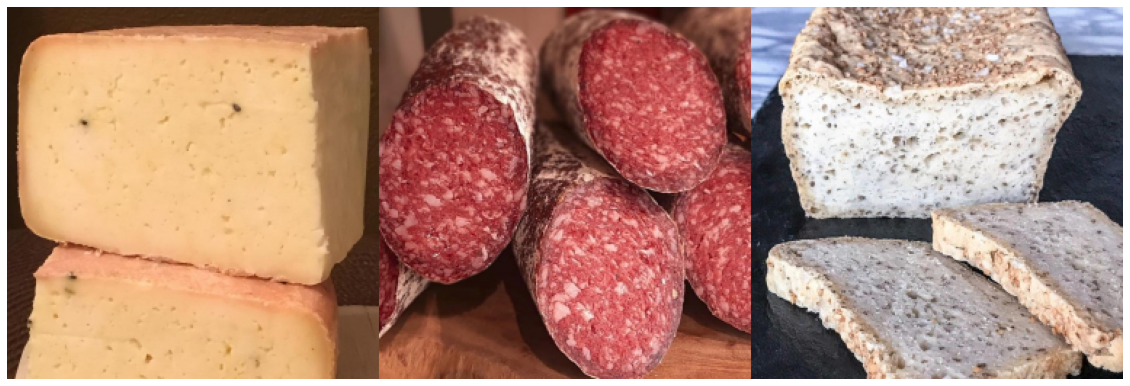

In [3]:
import os
import numpy as np

data_root = "./images"
images = np.array([
    load_image(os.path.join(data_root, filename)) 
    for filename in os.listdir(data_root)
])

display_images(images, cols=3, rows=1)

## Single image augmentation
Let us define a simple augmenter function

In [4]:
import albumentations as A

"""
This transformation will first randomly (with a probability of 0.8) 
change brightness and contrast of an image,
then it will randomly flip the image horizontally (with a probability of 0.5).
"""
augmenter = A.Compose([
    A.RandomBrightnessContrast(p=0.8),
    A.HorizontalFlip(p=0.5)
])

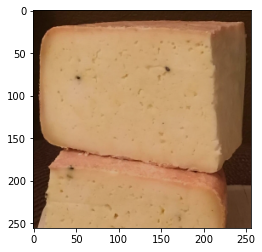

In [5]:
aug_image = augmenter(image=images[0])['image']
plt.imshow(aug_image)

## Sequence augmentation
As we want to generate an arbitrary number of images, given our dataset (three images in this case), we’ll need to define a Keras data sequence, that will sample an image from our data and augment it. To generate a batch using this method, we’ll perform sampling and augmentation until enough samples for our batch are generated.

In [6]:
import numpy as np
import os
import random

from tensorflow.keras.utils import Sequence

class DataSequence(Sequence):

    def __init__(self, data_root, batch_size, n_batches, augmenter, preprocess=lambda x: x):
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.augmenter = augmenter
        self.preprocess = preprocess
        # Get a list of images
        self.im_list = [
            os.path.join(data_root, filename) 
            for filename in os.listdir(data_root)
        ]
        self.n_avail_images = len(self.im_list)
        # Decide sampling function:
        # - If batch size is greater than number of available samples, 
        #   then sample with replacement (allow repetitions)
        # - Otherwise, sample without replacement (don't allow repetitions)
        self.sample = random.choices if batch_size >= self.n_avail_images else random.sample

    def __len__(self):
        return self.n_batches

    def __getitem__(self, batch_index):
        # Sample batch_size indices from our images list
        image_indexes = self.sample(range(self.n_avail_images), k=self.batch_size)
        batch_x = []
        batch_y = []
        # foreach sampled image index
        for image_idx in image_indexes:
            # get image path
            image_path = self.im_list[image_idx]
            # load image from path
            image = load_image(image_path)
            # apply augmentation
            image = self.augmenter(image=image)['image']
            # preprocess image
            image = self.preprocess(image)
            batch_x.append(image)
            # add a constant target value just for example completeness, 
            # (in a real scenario it would be loaded somehow)
            batch_y.append(1)
        # convert to numpy array
        batch_x = np.array(batch_x, dtype=np.float32)
        batch_y = np.array(batch_y, dtype=np.float32)
        return batch_x, batch_y

We can now instantiate the DataSequence object

In [7]:
batch_size = 32
n_batches = 8
augmenter = A.Compose([
    A.RandomBrightnessContrast(p=0.8),
    A.HorizontalFlip(p=0.5)
])
preprocess = lambda x: x / 255.0

data_seq = DataSequence('./images', batch_size, n_batches, augmenter, preprocess=preprocess)

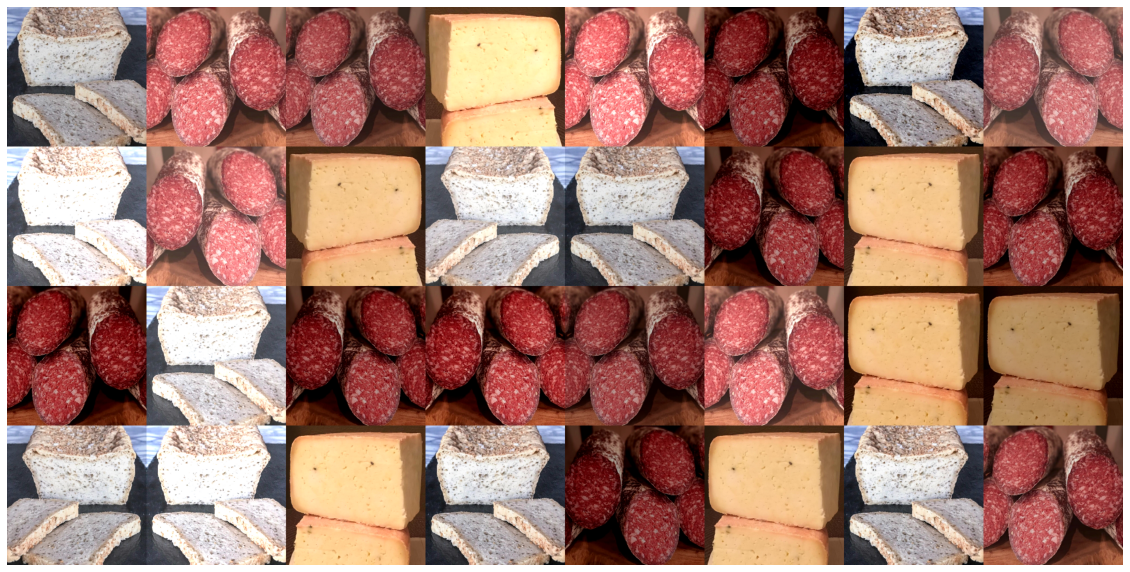

In [8]:
images, labels = next(iter(data_seq))
display_images(images)

As we can notice, the augmentation is working, however our images look very similar, as we initially started with only 3 images.

To obtain diverse samples given a low number of available images, we’ll need to apply “more aggressive” transformations, such as:

In [9]:
augmenter = A.Compose([
    A.RandomBrightnessContrast(p=0.8),
    A.OneOf([
        A.MotionBlur(blur_limit=12, p=1),
        A.GaussNoise(var_limit=(10, 50), p=1)
    ], p=1),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1, 
        scale_limit=0.2, 
        rotate_limit=0.3, 
        p=0.9, 
        border_mode=cv2.BORDER_REPLICATE
    )
])

In [10]:
data_seq = DataSequence('./images', batch_size, n_batches, augmenter, preprocess=preprocess)

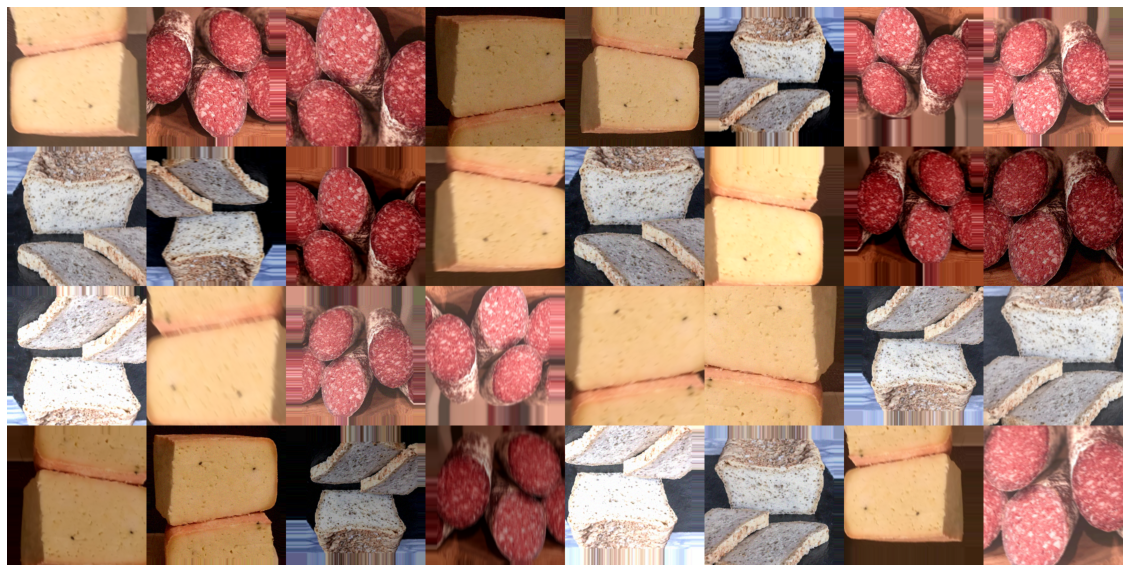

In [11]:
images, labels = next(iter(data_seq))
display_images(images)

**Note**: althought we got diverse images, it is always preferable to gather more training data to better exploit the augmentation process.

## Training integration
Assume we have a Keras model (sequential/functional/subclass, doesn't matter which one), then we can use our data sequence to fit our model in the following way:

model.fit(data_seq, epochs=N_EPOCHS)